In [334]:
import glob
import logging
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
from scipy.stats import gaussian_kde
import seaborn as sns
import sympy as sp

import importlib
import toylosses
importlib.reload(toylosses)
import toynn
importlib.reload(toynn)
import toyvis
importlib.reload(toyvis)


import torch
import torch.nn as tnn
from torch.nn import functional as F
sns.set()

random.seed(0)
np.random.seed(1)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Mixture of FA / PPCA
# Models parameters

W = np.array([
    [[2], [3]],  # W1
    [[-1], [1]],  # W2
    [[2], [1]]  # W3
])

mu = np.array([
    [2, 3],  # mu1
    [-1, 1],  # mu2
    [2, 1]  # mu3
])

probabilities = np.array([0.1, 0.6, 0.3])
# Sample latent variable, noise -> generate data
n = 1000
z = np.random.normal(size=(n, 1))
s = 0.1
eps = np.random.normal(loc=0, scale=s**2, size=(n, 2))  # PPCA because it is isotropic

# Generative model
c = np.random.choice([0, 1, 2], n, p=probabilities)

mask = np.zeros((n, 3))
for i in range(n): 
    mask[i] = c[i] == range(3)
ws = np.einsum('nm, mij->nij', mask, W)
mus = np.einsum('nm, mi->ni', mask, mu)
x = np.einsum('nij,nj->ni', ws, z) 
x = x + mus + eps

# Plot data
plt.scatter(x[:, 0], x[:, 1])
plt.axis('equal')

## Generating synthetic data from 2D model: x = W^T z + mu + eps

In [ ]:
# Models parameters
w1 = 2
w2 = 3
W = np.array([[w1], [w2]])
mu1 = -1
mu2 = 1
mu = np.array([mu1, mu2])
print(mu.shape)

# Sample latent variable, noise -> generate data
n = 100
z = np.random.normal(size=(n, 1))
print(z.shape)
s = 0.1
eps = np.random.normal(loc=0, scale=s**2, size=(n, 2))  # PPCA because it is isotropic
print(eps.shape)

# Generative model
x = np.einsum('ij,nj->ni', W, z) + mu + eps
x = np.maximum(x, 0)  # ReLu 
print(x.shape)
# Plot data
plt.scatter(x[:, 0], x[:, 1])
plt.axis('equal')

# Adding a second layer
v1 = -4
v2 = 7
V = np.array([[v1], [v2]])
m1 = 3
m2 = 5
m = np.array([m1, m2])
print(mu.shape)

# Generative model
h = np.einsum('ij,nj->ni', W, z) + mu
h = np.maximum(h, 0)  # ReLu 
eps = np.random.normal(loc=0, scale=s**2, size=(n, 2))  # PPCA because it is isotropic
x = np.einsum('ij,nj->ni', V, h) + m + eps
x = np.maximum(x, 0)  # ReLu 
print(x.shape)
# Plot data
plt.figure()
plt.scatter(x[:, 0], x[:, 1])
plt.axis('equal')

# Generate synthetic data from a VAE's decoder

Examples of parameters for the decoder

In [ ]:
w_true = {}
b_true = {}

w_true[0] = [[1.], [1.]]
b_true[0] = [0., -1.]

# For the reconstruction
w_true[1] = [[2., 1.], [-1., 2.]]
b_true[1] = [0., 0.]

# For the scale
w_true[2] = [[1., -1.], [0., 1.]]
b_true[2] = [0., 0.]


## Parameters 1

w_true = {}
b_true = {}

# For the reconstruction
w_true[0] = [[4.], [4.]]
b_true[0] = [0., -0.]

# For the scale
w_true[1] = [[-0.], [-0.]]
b_true[1] = [0., -0.]


## Parameters 2
DEVICE = 'cuda'

data_dim = 1
latent_dim = 1
n_layers = 1
nonlinearity = False
n_samples = 10000
with_biasx = False
with_logvarx = False

w_true = {}
b_true = {}

# For the reconstruction
w_true[0] = [[2.]]
if with_biasx:
    b_true[0] = [[0.]]

if with_logvarx:
    # For the scale
    w_true[1] = [[0.]]
    b_true[1] = [[0.]]


layers.0.weight tensor([[2.]], device='cuda:0') 

Covariance matrix from decoder:
4.925015160331548
Covariance matrix from synthetic:
5.016637077188237


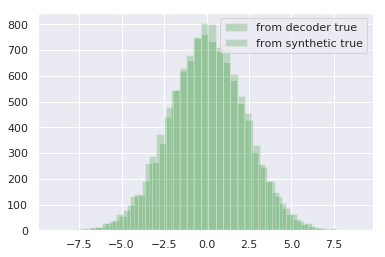

In [328]:
DEVICE = 'cuda'

data_dim = 1
latent_dim = 1
n_layers = 1
nonlinearity = False
n_samples = 10000
with_biasx = False
with_logvarx = False

w_true = {}
b_true = {}

# For the reconstruction
w_true[0] = [[2.]]
if with_biasx:
    b_true[0] = [[0.]]

if with_logvarx:
    # For the scale
    w_true[1] = [[0.]]
    b_true[1] = [[0.]]

decoder_true = toynn.make_decoder_true(
    w_true, b_true, latent_dim, data_dim, n_layers,
    nonlinearity, with_biasx, with_logvarx)

for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')
    

w_true = 2
color_true = 'green'
def generate_synthetic_1d(w=w_true, n=10):
    z = np.random.normal(loc=0, scale=1, size=(n, 1))
    eps = np.random.normal(loc=0, scale=1, size=(n, 1))

    x = w * z + eps
    return z, x

#generated_x = toynn.generate_from_decoder(decoder_true, n_samples)
_, synthetic_x = generate_synthetic_1d(w=w_true, n=n_samples)

generated_x = np.load(os.path.join(SYNTHETIC_DIR, 'dataset.npy'))

fig, ax = plt.subplots()
ax = toyvis.plot_data(generated_x, color='green', label='from decoder true', ax=ax)
ax = toyvis.plot_data(synthetic_x, color='green', label='from synthetic true', ax=ax)
ax.legend(loc='upper right')

print('Covariance matrix from decoder:')
cov = np.cov(generated_x.T)
print(cov)

print('Covariance matrix from synthetic:')
cov = np.cov(synthetic_x.T)
print(cov)


## Test loss functions

From the unregularized VAE:

\begin{align*}
    L_{ELBO} 
  = L_{UVAE} - KL_{prior}(\phi) 
  = \mathbb{E}_{p_{data}(x)}\left[ \mathbb{E}_{q_\phi(z|x)} \left[\log p_\theta(x|z)\right] - KL\left(q_\phi(z|x) || p(z)\right) \right] 
\end{align*}

Where the $\mathbb{E}$ is taken over the batch of data.

In [329]:
b_data = torch.Tensor(np.array([[0., 0., 0.], [0., 0., 0.]])).to(DEVICE)
b_recon = torch.Tensor(np.array([[2., 2., 2.], [3., 3., 3.]])).to(DEVICE)

b_logvarx = torch.Tensor(np.array([[np.log(1.)], [np.log(2.)]])).to(DEVICE)
print('1111', toylosses.reconstruction_loss(b_data, b_recon, b_logvarx))

#expected_ssd = tensor([12., 27.])
#expected_ssd_term = tensor([-6.0000, -6.7500])

b_data = torch.Tensor(np.array([[0., 0., 0.], [0., 0., 0.]])).to(DEVICE)
b_recon = torch.Tensor(np.array([[2., 2., 2.], [3., 3., 3.]])).to(DEVICE)

b_logvarx = torch.Tensor(
    np.array(
        [[np.log(1.), np.log(1.), np.log(1.)], 
         [np.log(2.), np.log(2.), np.log(2.)]])).to(DEVICE)
print('2222', toylosses.reconstruction_loss(b_data, b_recon, b_logvarx))
#1111 tensor(9.6517, device='cuda:0')
#2222 tensor(9.6517, device='cuda:0')

1111 tensor(9.6517, device='cuda:0')
2222 tensor(9.6517, device='cuda:0')


by modifying the VAE criterion and integrating GANs, we can provide a NN implementation of the variational EM.

- Send a batch through the VAE
- Compute the VAE loss: the reconstruction error and the regularization
- back propagate through the entire VAE
- update only the encoder: this will update it wrt to the -KL( || posterior), this is the E step of the variational EM.
- Generate N data Z from the prior
- Propagate through the decoder
- Use a GAN to distinguish the distribution in $\tilde x$ from N data from the true distribution: generate ONE sample Z, and ask the discriminator.
- back propagate this through the decoder
- update the decoder w.r.t. only this.

## Inspect results from standard VAE

-- True values of parameters
layers.0.weight tensor([[2.]], device='cuda:0') 


-- Learnt values of parameters
layers.0.weight tensor([[-1.1069]], device='cuda:0') 

Last losses:
[0.04510449677705765, 0.04495921102166176, 0.04458578377962112, 0.044399454712867735, 0.044013446182012556]


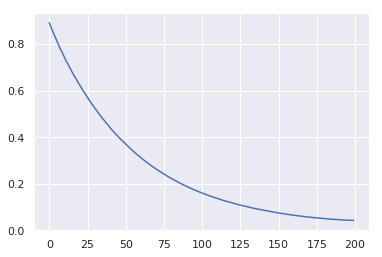

In [338]:
PATH = '/scratch/users/nmiolane/toyoutput'

decoder_true_path = glob.glob(f'{PATH}/synthetic/decoder_true.pth')[0]
decoder_true = torch.load(decoder_true_path, map_location=DEVICE)

decoder_path = glob.glob(f'{PATH}/train_vae/models/decoder.pth')[0]
decoder = torch.load(decoder_path, map_location=DEVICE)

print('-- True values of parameters')
for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')

decoder = modules['decoder']
print('\n-- Learnt values of parameters')
for name, param in decoder.named_parameters():
    print(name, param.data, '\n')
    
losses_vae_path = glob.glob(f'{PATH}/train_vae/train_losses.pkl')[0]
train_losses_all_epochs = pickle.load(open(losses_vae_path, 'rb'))

plt.figure()
train_losses_total = [loss['total'] for loss in train_losses_all_epochs]
n_epochs = len(train_losses_total)
plt.plot(range(n_epochs), train_losses_total)
print('Last losses:')
print(train_losses_total[-5:])

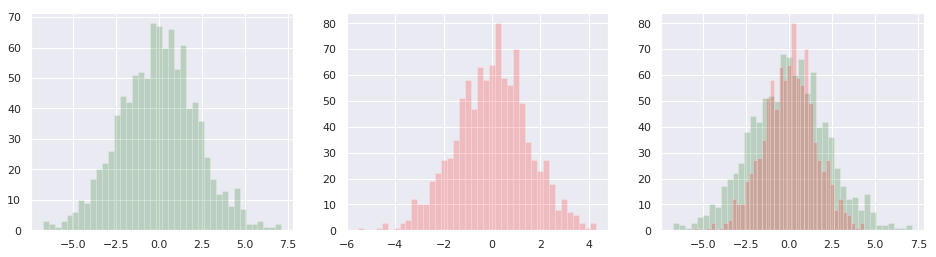

In [339]:
n_samples = 1000
generated_true_x = toynn.generate_from_decoder(decoder_true, n_samples)
generated_x = toynn.generate_from_decoder(decoder, n_samples)

# For 1D
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))
axis_side = 20

ax = axes[0]
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)

ax = axes[1]
toyvis.plot_data(generated_x, color='red', ax=ax)

ax = axes[2]
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)
toyvis.plot_data(generated_x, color='red', ax=ax)

AttributeError: 'str' object has no attribute 'hist'

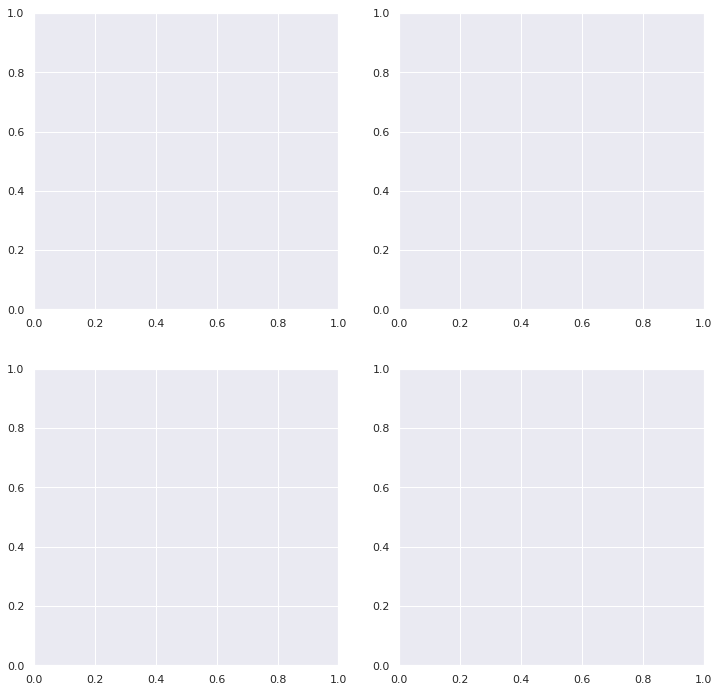

In [241]:
# For 2D
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
axis_side = 20

ax = axes[0, 0]
plot_data(generated_true_x, color='darkgreen')

ax = axes[0, 1]
plot_data(generated_x, color='red')

ax = axes[1, 0]
plot_kde(generated_true_x, ax, 'Greens', axis_side)

ax = axes[1, 1]
plot_kde(generated_x, ax, 'Reds', axis_side)

In [20]:
def risk(theta):
    #loglikelihood_i = ... theta ...

    n_samples = 1000
    generated_true_x = generate_from_decoder(decoder_true, n_samples)
    risk = - np.mean([loglikelihood_i.subs({x_i: sp.Matrix(x_elt)}) for x_elt in generated_true_x])
    return risk

## Inspect results from VEM

-- True values of parameters
layers.0.weight tensor([[2.]], device='cuda:0') 


-- Learnt values of parameters
layers.0.weight tensor([[-1.1069]], device='cuda:0') 

Last losses:
[0.07946083056926727, 0.07973410743474961, 0.07932572066783905, 0.07929224586486816, 0.07929456669092179]


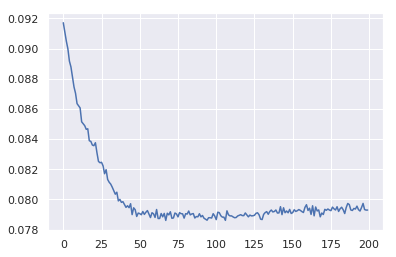

In [340]:
PATH = '/scratch/users/nmiolane/toyoutput'

decoder_true_path = glob.glob(f'{PATH}/synthetic/decoder_true.pth')[0]
decoder_true = torch.load(decoder_true_path, map_location=DEVICE)

decoder_path = glob.glob(f'{PATH}/train_vem/models/decoder.pth')[0]
decoder = torch.load(decoder_path, map_location=DEVICE)

print('-- True values of parameters')
for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')

decoder = modules['decoder']
print('\n-- Learnt values of parameters')
for name, param in decoder.named_parameters():
    print(name, param.data, '\n')
    
losses_vae_path = glob.glob(f'{PATH}/train_vem/train_losses.pkl')[0]
train_losses_all_epochs = pickle.load(open(losses_vae_path, 'rb'))

plt.figure()
train_losses_total = [loss['total'] for loss in train_losses_all_epochs]
n_epochs = len(train_losses_total)
plt.plot(range(n_epochs), train_losses_total)
print('Last losses:')
print(train_losses_total[-5:])

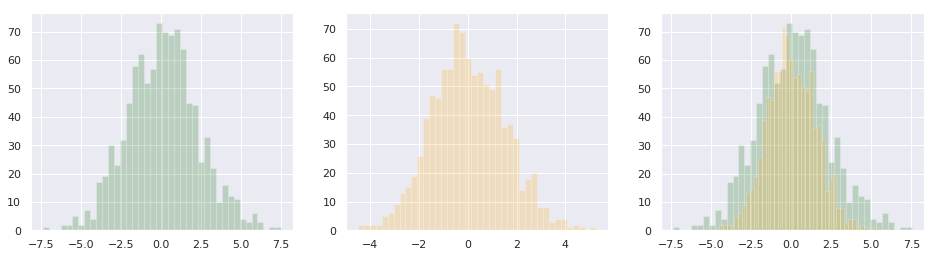

In [342]:
n_samples = 1000
generated_true_x = generate_from_decoder(decoder_true, n_samples)
generated_x = generate_from_decoder(decoder, n_samples)

# For 1D
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))
axis_side = 20

ax = axes[0]
plot_data(generated_true_x, color='darkgreen', ax=ax)

ax = axes[1]
plot_data(generated_x, color='orange', ax=ax)

ax = axes[2]
plot_data(generated_true_x, color='darkgreen', ax=ax)
plot_data(generated_x, color='orange', ax=ax)